In [37]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, GRU, Dropout, Activation
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import SimpleRNN, Embedding
from tensorflow.keras.preprocessing import sequence

from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis

### Read data ###

In [3]:
df = pd.read_csv('./Bitcoin Historical Data.csv')

In [4]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2024,"67,760.8","67,533.9","67,861.0","67,449.6",19.01K,0.34%
1,05/31/2024,"67,530.1","68,352.3","69,018.2","66,676.8",61.51K,-1.21%
2,05/30/2024,"68,354.7","67,631.3","69,504.7","67,138.4",66.84K,1.06%
3,05/29/2024,"67,635.8","68,366.2","68,897.6","67,143.2",52.13K,-1.07%
4,05/28/2024,"68,366.0","69,428.3","69,560.7","67,299.9",71.39K,-1.53%


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1920 non-null   object
 1   Price     1920 non-null   object
 2   Open      1920 non-null   object
 3   High      1920 non-null   object
 4   Low       1920 non-null   object
 5   Vol.      1920 non-null   object
 6   Change %  1920 non-null   object
dtypes: object(7)
memory usage: 105.1+ KB


In [6]:
def convert_to_number(price_str):
    price_str = price_str.replace(",", "")  # Remove any commas
    if 'K' in price_str:
        return float(price_str.replace('K', '')) * 1000
    elif 'M' in price_str:
        return float(price_str.replace('M', '')) * 1000000
    elif 'B' in price_str:
        return float(price_str.replace('B', '')) * 1000000000
    elif '%' in price_str:
        return float(price_str.replace('%', '')) / 100
    else:
        return float(price_str)

In [7]:
df['Date']  = pd.to_datetime(df['Date'])
df.reset_index(drop=True)
df.set_index('Date', inplace=True)
df['Vol.']   = df['Vol.'].apply(convert_to_number)
df.rename(columns={'Vol.': 'Vol'}, inplace=True)
df['Change %'] = df['Change %'].apply(convert_to_number)
df.rename(columns={'Change %': 'Change'}, inplace=True)
df['Price'] = df['Price'].apply(convert_to_number)
df['Open']  = df['Open'].apply(convert_to_number)
df['High']  = df['High'].apply(convert_to_number)
df['Low']   = df['Low'].apply(convert_to_number)

In [8]:
df.head()

,Price,Open,High,Low,Vol,Change
Date,,,,,,
2024-06-01,67760.8,67533.9,67861.0,67449.6,19010.0,0.0034
2024-05-31,67530.1,68352.3,69018.2,66676.8,61510.0,-0.0121
2024-05-30,68354.7,67631.3,69504.7,67138.4,66840.0,0.0106
2024-05-29,67635.8,68366.2,68897.6,67143.2,52130.0,-0.0107
2024-05-28,68366.0,69428.3,69560.7,67299.9,71390.0,-0.0153


### Descriptive statistc ###

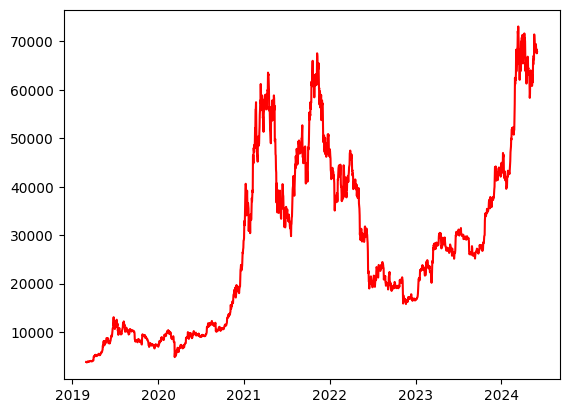

In [9]:
plt.figure()
plt.plot(df["Price"], color='red')
plt.show()

<Axes: >

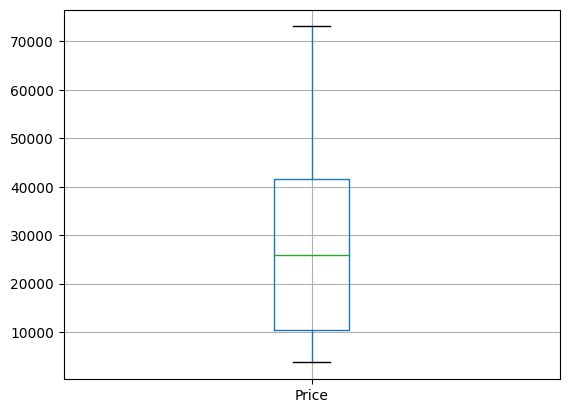

In [10]:
df.boxplot(column=['Price'])

In [11]:
column='Price'
summary = {
    'mean': df[column].mean(),
    'mode': df[column].mode()[0], 
    'std': df[column].std(),
    'var': df[column].var(),
    'kurtosis': kurtosis(df[column]),
    'skewness': skew(df[column]),
    'range': df[column].max() - df[column].min(),
    'min': df[column].min(),
    'max': df[column].max(),
    'sum': df[column].sum(),
    'count': df[column].count(),
    'median': df[column].median()
}

print(f"Summary statistics for column {column}:")
for stat, value in summary.items():
    print(f"{stat}: {value}")


Summary statistics for column Price:
mean: 27920.39703125
mode: 7196.4
std: 17920.190889380487
var: 321133241.51183546
kurtosis: -0.6942125412759332
skewness: 0.575416335730235
range: 69350.40000000001
min: 3715.9
max: 73066.3
sum: 53607162.3
count: 1920
median: 25933.35


In [12]:
df['Price'].describe()

count     1920.000000
mean     27920.397031
std      17920.190889
min       3715.900000
25%      10435.625000
50%      25933.350000
75%      41491.000000
max      73066.300000
Name: Price, dtype: float64

### Preprocess data ###

In [13]:

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

In [14]:
df.head()

,Price,Open,High,Low,Vol,Change,Year,Month,Day
Date,,,,,,,,,
2024-06-01,67760.8,67533.9,67861.0,67449.6,19010.0,0.0034,2024,6,1
2024-05-31,67530.1,68352.3,69018.2,66676.8,61510.0,-0.0121,2024,5,31
2024-05-30,68354.7,67631.3,69504.7,67138.4,66840.0,0.0106,2024,5,30
2024-05-29,67635.8,68366.2,68897.6,67143.2,52130.0,-0.0107,2024,5,29
2024-05-28,68366.0,69428.3,69560.7,67299.9,71390.0,-0.0153,2024,5,28


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2024-06-01 to 2019-03-01
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1920 non-null   float64
 1   Open    1920 non-null   float64
 2   High    1920 non-null   float64
 3   Low     1920 non-null   float64
 4   Vol     1920 non-null   float64
 5   Change  1920 non-null   float64
 6   Year    1920 non-null   int64  
 7   Month   1920 non-null   int64  
 8   Day     1920 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 150.0 KB


In [16]:
df.shape

(1920, 9)

### Parameter

In [17]:
window_size = 10
feature_dim = 5
test_size=0.2

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

### Split data

In [18]:
df_train = df[df.index<='3/1/2024']
df_test = df[df.index>'3/1/2024']


In [19]:
print('df_train.shape: ',df_train.shape)
print('df_trest.shape: ',df_test.shape)

df_train.shape:  (1828, 9)
df_trest.shape:  (92, 9)


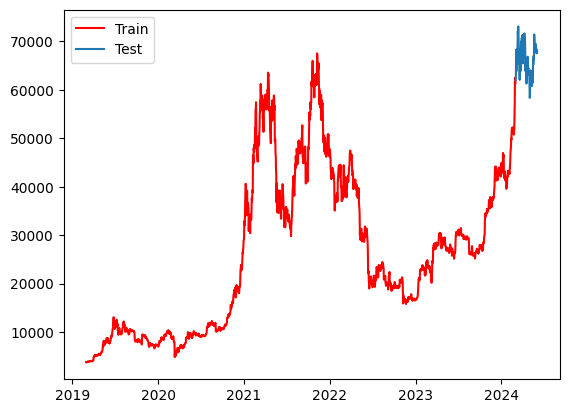

In [20]:
plt.figure()
plt.plot(pd.DataFrame(df_train).index.to_list(), pd.DataFrame(df_train['Price']), color='red', label='Train')
plt.plot(pd.DataFrame(df_test).index.to_list(),pd.DataFrame(df_test['Price']), label ='Test')
plt.legend()
plt.show()

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, index=df_test.index, columns=df_test.columns)

In [22]:
X_train_flat = df_train_scaled.drop(columns=['Price'])
y_train_flat = df_train_scaled['Price']
X_test_flat = df_test_scaled.drop(columns=['Price'])
y_test_flat = df_test_scaled['Price']

In [23]:
print('X_train_flat shape: ',X_train_flat.shape)
print('y_train_flat shape: ',y_train_flat.shape)
print('X_test_flat shape: ',X_test_flat.shape)
print('y_test_flat shape: ',y_test_flat.shape)

X_train_flat shape:  (1828, 8)
y_train_flat shape:  (1828,)
X_test_flat shape:  (92, 8)
y_test_flat shape:  (92,)


In [24]:
def train_test_split(X_train, y_train,X_test,y_test,test_size, window_size=10):
    if window_size is not None:
        X_train = np.array([X_train[i:i+window_size] for i in range(len(X_train)-window_size)])
        y_train = y_train[window_size:]
        X_test = np.array([X_test[i:i+window_size] for i in range(len(X_test)-window_size)])
        y_test = y_test[window_size:]
    return X_train, y_train, X_test, y_test

In [25]:
X_train, y_train, X_test, y_test=train_test_split(X_train_flat,y_train_flat,X_test_flat,y_test_flat,window_size)

In [26]:
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (1818, 10, 8)
y_train shape:  (1818,)
X_test shape:  (82, 10, 8)
y_test shape:  (82,)


### Linear Regression ###

In [28]:
model_LR = LinearRegression()
model_LR.fit(X_train_flat, y_train_flat)

LinearRegression()

In [30]:
pred_LR = model_LR.predict(X_test_flat)

In [31]:
mape = mean_absolute_percentage_error(y_test_flat, pred_LR)
mae = mean_absolute_error(y_test_flat,pred_LR)
mse = mean_squared_error(y_test_flat, pred_LR)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.008036169915767777
Mean Absolute Error: 0.007832022670317079
Root Mean Squared Error: 0.01013416673364472


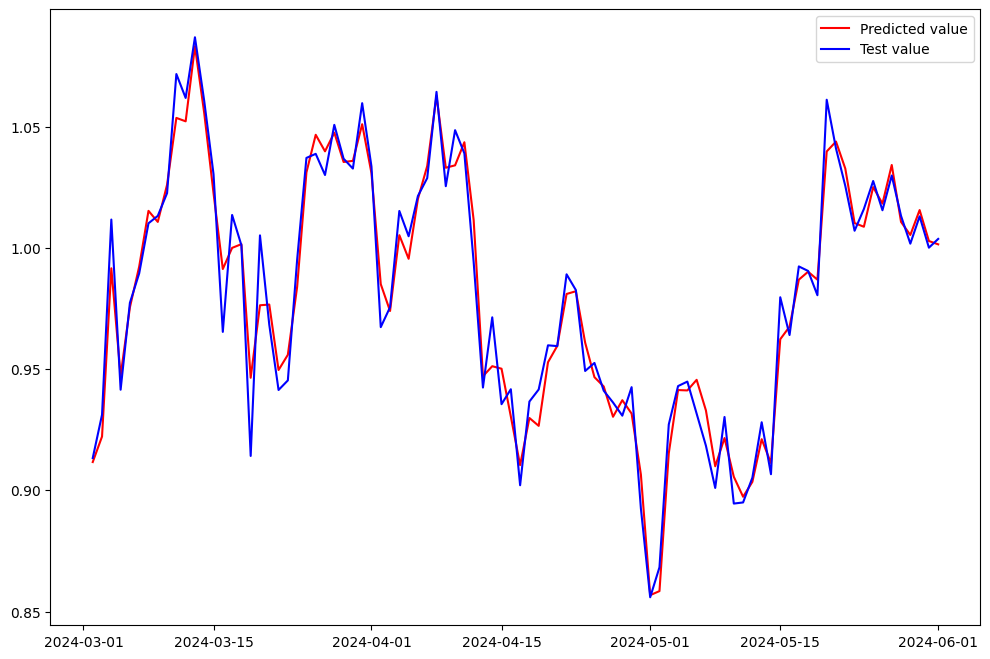

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test_flat).index.to_list(), pd.DataFrame(pred_LR.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test_flat).index.to_list(), pd.DataFrame(y_test_flat), color='blue', label='Test value')
plt.legend()
plt.show()

In [38]:
model_filename = "model_LR.joblib"
joblib.dump(model_LR, model_filename)

['model_LR.joblib']

### GRU ###

In [120]:
def build_GRU_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):                     
    model = Sequential()

    model.add(GRU(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [121]:
model_GRU = build_GRU_model(
    (X_train.shape[1],X_train.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [122]:
history = model_GRU.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [123]:
model_GRU.save('model_GRU.h5')

In [124]:
pred_GRU = model_GRU.predict(X_test)
mape = mean_absolute_percentage_error(y_test, pred_GRU)
mae = mean_absolute_error(y_test,pred_GRU)
mse = mean_squared_error(y_test, pred_GRU)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

3/3 [==============================] - 0s 3ms/step
Mean Absolute Percentage Error: 0.06682547745661244
Mean Absolute Error: 0.06559739535521342
Root Mean Squared Error: 0.06624336175457941


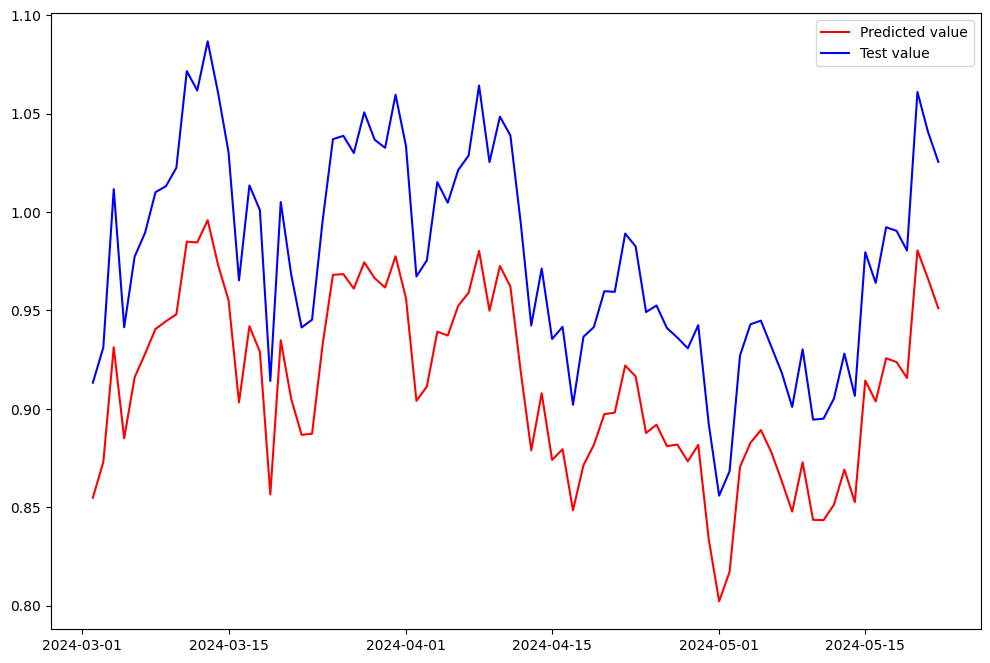

In [125]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(pred_GRU.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.legend()
plt.show()

### RNN ###

In [155]:
def build_RNN_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'): 
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(optimizer='adam', loss='mse')

    model.compile(loss =loss, optimizer=optimizer)
    return model

In [156]:
model_RNN = build_RNN_model((X_train.shape[1],X_train.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [157]:
history = model_RNN.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [160]:
model_RNN.save('model_RNN.h5')

In [158]:
pred_RNN = model_RNN.predict(X_test)
mape = mean_absolute_percentage_error(y_test, pred_RNN)
mae = mean_absolute_error(y_test,pred_RNN)
mse = mean_squared_error(y_test, pred_RNN)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

3/3 [==============================] - 0s 3ms/step
Mean Absolute Percentage Error: 0.00313837995744097
Mean Absolute Error: 0.0030425831052961535
Root Mean Squared Error: 0.003536948533665621


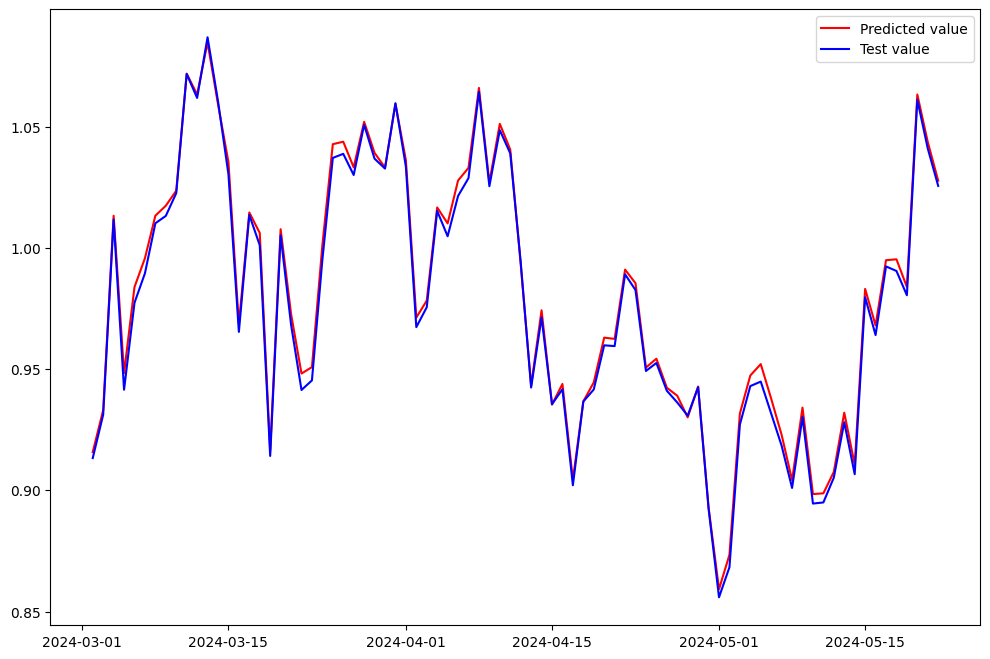

In [159]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(pred_RNN.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.legend()
plt.show()

### LSTM ###

In [127]:
def build_lstm_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [128]:
model_LSTM = build_lstm_model(
    (X_train.shape[1],X_train.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [129]:
history = model_LSTM.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [130]:
model_LSTM.save('model_LSTM.h5')

In [131]:
pred_LSTM = model_LSTM.predict(X_test)
mape = mean_absolute_percentage_error(y_test, pred_LSTM)
mae = mean_absolute_error(y_test,pred_LSTM)
mse = mean_squared_error(y_test, pred_LSTM)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

3/3 [==============================] - 0s 5ms/step
Mean Absolute Percentage Error: 0.010726876582960444
Mean Absolute Error: 0.010706464702595002
Root Mean Squared Error: 0.012345719991826029


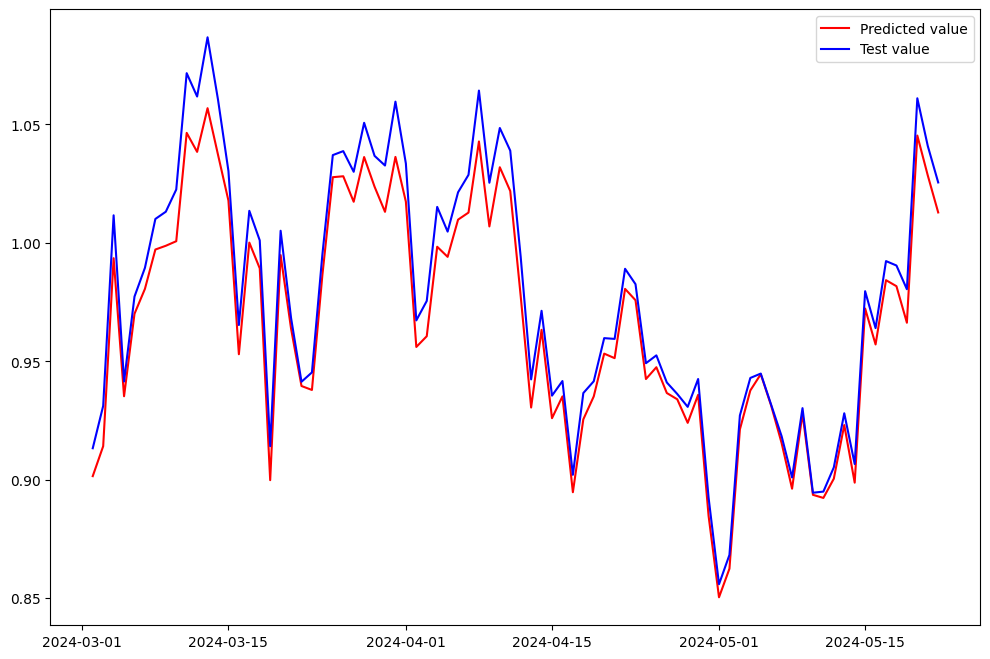

In [132]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(pred_LSTM.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.legend()
plt.show()

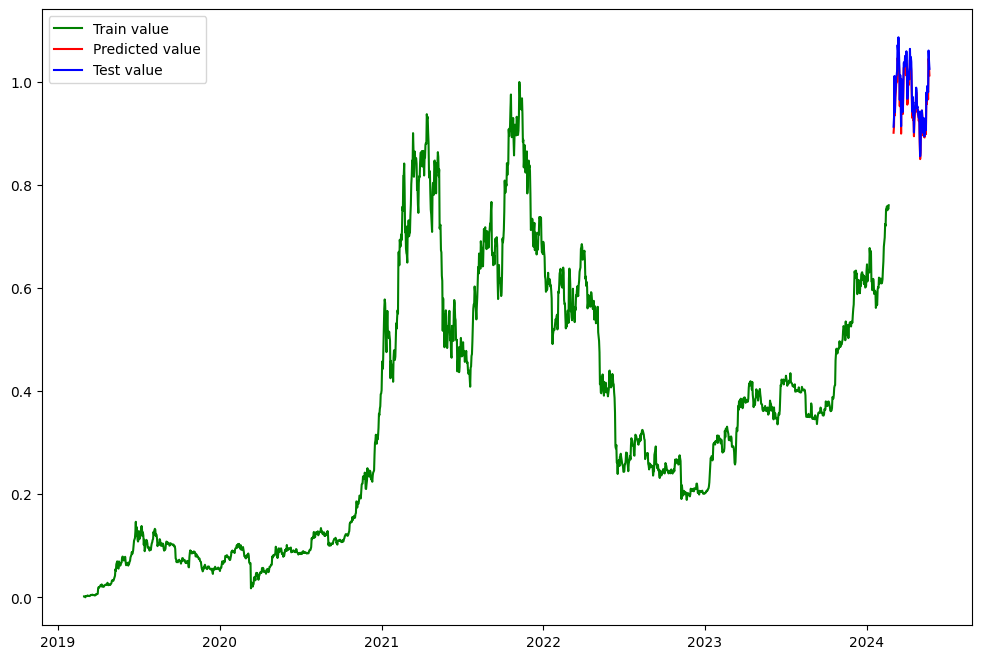

In [133]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='green',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(pred_LSTM.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.legend()
plt.show()

### AUTOFORMER ###

### SARIMAX ###

### STACKING MODELS ###

In [134]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Base model 

In [135]:
base_model_GRU = build_GRU_model(
    (X_train.shape[1],X_train.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [136]:
base_model_LSTM = build_lstm_model(
    (X_train.shape[1],X_train.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

First base model (GRU)

In [137]:
prediction_GRU_stacking = pd.DataFrame()
test_GRU_prediction={}
i=0
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    base_model_GRU.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_pred_fold = base_model_GRU.predict(X_test_fold)
    test_GRU_prediction[f'test_{i}'] = base_model_GRU.predict(X_test)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_pred_fold, columns=['Prediction'])
    prediction_GRU_stacking = pd.concat([prediction_GRU_stacking, y_pred_fold_df], axis=0, ignore_index=True)

Epoch 1/10
46/46 [==============================] - 2s 7ms/step - loss: 0.1786
Epoch 2/10
46/46 [==============================] - 0s 5ms/step - loss: 0.1089
Epoch 3/10
46/46 [==============================] - 0s 6ms/step - loss: 0.0800
Epoch 4/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0708
Epoch 5/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0654
Epoch 6/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0590
Epoch 7/10
46/46 [==============================] - 0s 4ms/step - loss: 0.0568
Epoch 8/10
46/46 [==============================] - 0s 4ms/step - loss: 0.0528
Epoch 9/10
46/46 [==============================] - 0s 4ms/step - loss: 0.0498
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
46/46 [==============================] - 0s 6ms/step - loss: 0.0434
Epoch 2/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 3/10
46/46 [==============================] - 0s 4ms/step - lo

In [138]:
num_elements = len(next(iter(test_GRU_prediction.values())))
test_GRU_average = []

for i in range(num_elements):
    element_sum = sum(test_GRU_prediction[key][i] for key in test_GRU_prediction)
    test_GRU_average.append(element_sum / len(test_GRU_prediction))
test_GRU_average = pd.DataFrame(test_GRU_average)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_pred_meta.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.legend()
plt.show()

Second base model (LSTM)

In [139]:
prediction_LSTM_stacking = pd.DataFrame()
test_LSTM_prediction={}
i=0
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    base_model_LSTM.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_pred_fold = base_model_LSTM.predict(X_test_fold)
    test_LSTM_prediction[f'test_{i}'] = base_model_LSTM.predict(X_test)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_pred_fold, columns=['Prediction'])
    prediction_LSTM_stacking = pd.concat([prediction_LSTM_stacking, y_pred_fold_df], axis=0, ignore_index=True)

Epoch 1/10
46/46 [==============================] - 2s 7ms/step - loss: 0.3202
Epoch 2/10
46/46 [==============================] - 0s 10ms/step - loss: 0.1182
Epoch 3/10
46/46 [==============================] - 0s 8ms/step - loss: 0.0878
Epoch 4/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0641
Epoch 5/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0554
Epoch 6/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0537
Epoch 7/10
46/46 [==============================] - 0s 4ms/step - loss: 0.0505
Epoch 8/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 9/10
46/46 [==============================] - 0s 4ms/step - loss: 0.0450
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
46/46 [==============================] - 0s 4ms/step - loss: 0.0449
Epoch 2/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 3/10
46/46 [==============================] - 0s 5ms/step - l

In [140]:
num_elements = len(next(iter(test_LSTM_prediction.values())))
test_LSTM_average = []

for i in range(num_elements):
    element_sum = sum(test_LSTM_prediction[key][i] for key in test_LSTM_prediction)
    test_LSTM_average.append(element_sum / len(test_LSTM_prediction))

test_LSTM_average = pd.DataFrame(test_LSTM_average)

Train dataset for meta model

In [141]:
train_meta = pd.concat([prediction_LSTM_stacking, prediction_GRU_stacking], axis=1, ignore_index=True)

Test dataset for meta model

In [142]:
test_meta = pd.concat([test_LSTM_average,test_GRU_average],axis=1, ignore_index=True)

meta model training

In [146]:
X_train_meta =train_meta
y_train_meta = y_train
X_test_meta = test_meta
y_test_meta = y_test

In [147]:
print('X train shape of meta model: ', X_train_meta.shape)
print('y train shape of meta model: ',y_train_meta.shape)
print('X test shape of meta model', X_test_meta.shape)
print('y test shape of meta model',y_test_meta.shape)

X train shape of meta model:  (1818, 2)
y train shape of meta model:  (1818,)
X test shape of meta model (82, 2)
y test shape of meta model (82,)


In [151]:
meta_model = RandomForestRegressor(n_estimators=100, random_state=42)
meta_model.fit(X_train_meta, y_train_meta)

RandomForestRegressor(random_state=42)

In [153]:
y_pred_meta = meta_model.predict(X_test_meta)
mape = mean_absolute_percentage_error(y_test_meta, y_pred_meta)
mae = mean_absolute_error(y_test_meta,y_pred_meta)
mse = mean_squared_error(y_test_meta, y_pred_meta)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.8010684795140492
Mean Absolute Error: 0.786717316339308
Root Mean Squared Error: 0.7969625082666


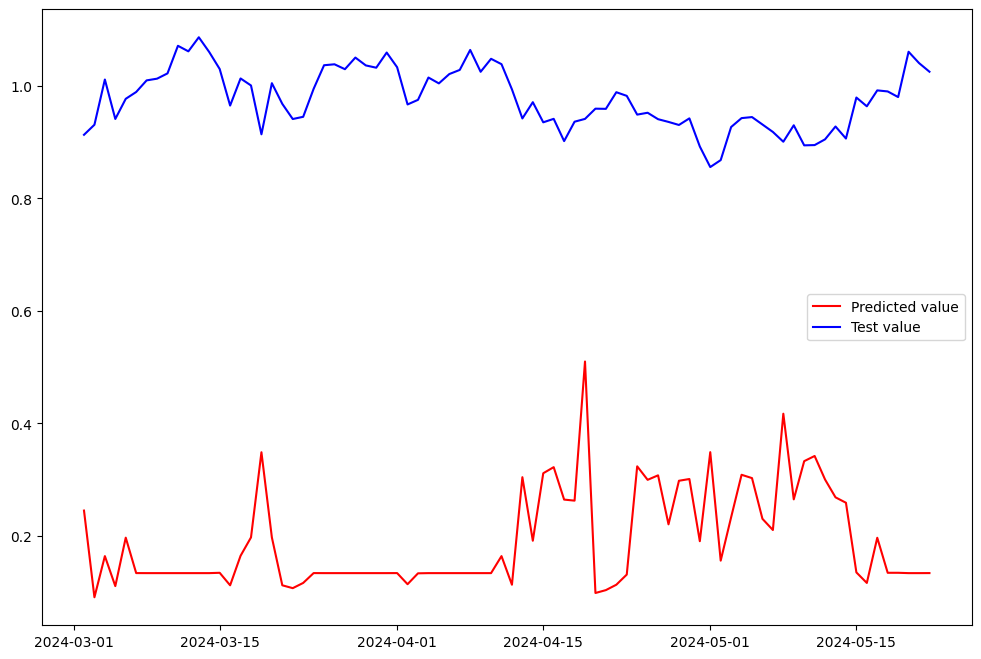

In [154]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_pred_meta.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.legend()
plt.show()

### ARIMA ###